# Continuous Optimisation HW2

In [2]:
# Imports
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from tqdm import tqdm
from scipy.io import loadmat
import time


data = loadmat('data-toy.mat')
print(data.keys())
sigma = float(data['sigma'])

'''
K = data['K']
P = data['P']
X0 = data['X0']
d = data['d']
delta_0 = data['delta_0']
delta_bar = data['delta_bar']
n = data['n']
sigma = data['sigma']
y = data['y']
'''

sigmasquared = sigma**2


dict_keys(['__header__', '__version__', '__globals__', 'K', 'P', 'X0', 'Xstar', 'd', 'delta_0', 'delta_bar', 'n', 'sigma', 'y'])


C:\Users\gzein\AppData\Local\Temp\ipykernel_8920\2921735262.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = float(data['sigma'])


# Question 1
Implement phi(x, P), bigphi(X, P), f(X, P, y).

In [3]:
# Question 1
#TODO Vectorise all the functions

def h(x: np.ndarray) -> float:
    """
    Gaussian filter

    :x: np.ndarray[(1, 2)]
    :returns: float
    """
    return np.e**(-np.inner(x, x)/sigmasquared)  # Always take sigma = 0.1


def phi(x,P):
    """
    Calculate contribution of each 'true' star to observed image
    
    :x: np.ndarray[(2, 1)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(n**2, 1)]
    """
    # print(f"P is {P}")
    # print(f"x is {x}")
    # print(f"P-x is {P-x}")
    # print(h(P - x).reshape(-1, 1))
    # print((np.e**((-1/sigmasquared)*np.sum((P.T-x.T)**2,axis=1))).reshape(-1, 1))
    # return h(P - x).reshape(-1, 1)
    return (np.e**((-1/sigmasquared)*np.sum((P.T-x.T)**2,axis=1))).reshape(-1, 1)


def bigphi(X, P):
    """
    Calculate image observed, based on K-star positions X
    
    :X: np.ndarray[(2, K)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(n**2, 1)]
    """
    global K, n
    X = X.flatten()
    #non-vectorised code just in case we need it
    bigphi = np.zeros((n**2, 1))
    for i in range(K):
        bigphi += phi(X[2*i:2*i+2], P)
    #return phi(X, P)
    return bigphi


def  f(X, P, y):
    """
    Calculate squared error of estimate bigphi(X)
    
    :X: np.ndarray[(2, K)]
    :P: np.ndarray[(2, n**2)]
    :y: np.ndarray[(n**2, 1)]
    :returns: float
    """
    global n
    return (1/(2*n**2)) * np.linalg.norm(bigphi(X, P)-y)**2


# Question 2

We see that $f$ is not convex. There are clear local maxima which cannot occur if $f$ were convex.

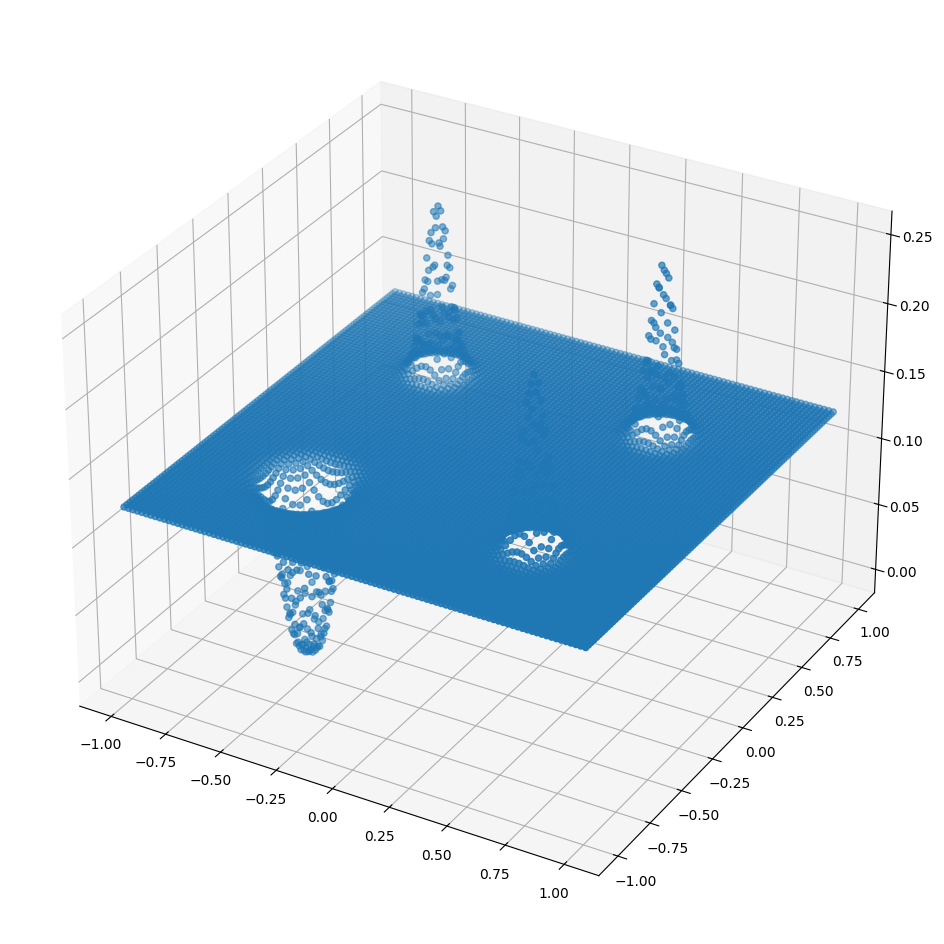

In [4]:
K = 1
n = 2
true_positions = np.array([[0], [0]])
positions = np.array([[0.5, 0.5], [-0.5, 0.5], [-0.5, -0.5], [0.5, -0.5]]).T
y = np.array([[0], [0], [1], [0]])
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

x_vals = np.linspace(-1, 1, 100)
y_vals = np.linspace(-1, 1, 100)
x_vals, y_vals = np.meshgrid(x_vals, y_vals)
grid = np.array([x_vals, y_vals]).reshape((2, 100**2))
z_vals = np.zeros((1, 10000))
for i in range(10000):
    z_vals[0, i] = f(grid[:, i].reshape((2, 1)), positions, y)
z_vals = z_vals.reshape((100, 100))
ax.scatter(x_vals, y_vals, z_vals)
plt.show()
plt.show()

# Question 6.1

In [5]:
def d_phi_i_0(x,p_i):
    """
    Computes value of cell i_0 of jacobian of phi
    
    :x: np.ndarray[(2, 1)]
    :p_i: np.ndarray[(2, 1)]
    :returns: float
    """
    return (2/sigmasquared)*(p_i[0]-x[0])*np.e**((-1/sigmasquared)*np.inner(p_i-x,p_i-x))

def d_phi_i_1(x,p_i):
    """
    Computes value of cell i_1 of jacobian of phi
    
    :x: np.ndarray[(2, 1)]
    :p_i: np.ndarray[(2, 1)]
    :returns: float
    """
    return (2/sigmasquared)*(p_i[1]-x[1])*np.e**((-1/sigmasquared)*np.inner(p_i-x,p_i-x))
    
def d_phi(x, P):
    """
    Computes the jacobian of small phi

    :x: np.ndarray[(1, 2)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(n**2, 2)]
    """
    # Subtract x from each column of P
    diff = P.T - x
    # Compute the squared differences
    squared_diff = np.sum(diff**2, axis=1)
    # Compute the exponential term for all elements at once
    exp_term = np.exp((-1 / sigmasquared) * squared_diff)
    # Compute the values for d_phi_i_0 and d_phi_i_1 using vectorized operations
    d_phi_0 = (2 / sigmasquared) * diff[:, 0] * exp_term
    d_phi_1 = (2 / sigmasquared) * diff[:, 1] * exp_term
    # Stack the results to form the final array
    d_phi = np.stack((d_phi_0, d_phi_1), axis=1)
    return d_phi

def d_big_phi(X,P):
    """
    Computes the jacobian of big phi

    :X: np.ndarray[(1, 2K)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(n**2, 2K)]
    """
    d_big_phi = np.zeros((n**2,2*K))
    for i in range(K):
        d_big_phi[0:n**2,2*i:2*i+2] = d_phi(X[2*i:2*i+2].T,P)
    return d_big_phi

def d_f(X,P):
    """
    Computes the jacobian of f

    :X: np.ndarray[(1, 2K)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(1, 2K)]
    """
    return (1/n**2)*(bigphi(X,P)-y).T@d_big_phi(X,P)

#compute gradient of f
def grad_f(X,P):
    """
    Computes the gradient of f

    :X: np.ndarray[(1, 2K)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(2K, 1)]
    """
    return d_f(X,P).T

# Question 6.2

C:\Users\gzein\AppData\Local\Temp\ipykernel_8920\2354262383.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K = int(data['K'])
C:\Users\gzein\AppData\Local\Temp\ipykernel_8920\2354262383.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d = int(data['d'])
C:\Users\gzein\AppData\Local\Temp\ipykernel_8920\2354262383.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(data['n'])
C:\Users\gzein\AppData\Local\Temp\ipykernel_8920\2354262383.py:9: Deprecatio

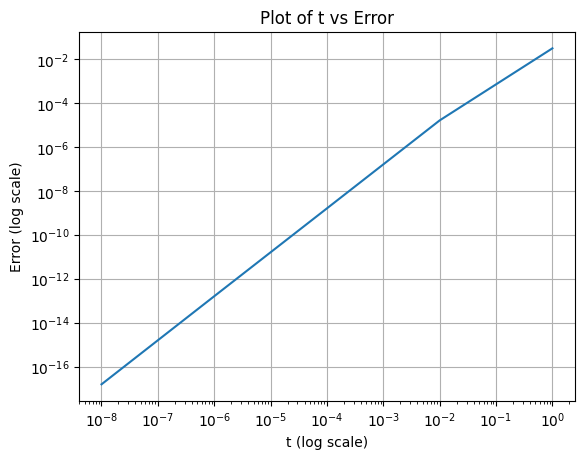

In [6]:
#checking gradient is correct numerically
K = int(data['K'])
P = data['P']
X0 = data['X0']
d = int(data['d'])
delta_0 = data['delta_0']
delta_bar = data['delta_bar']
n = int(data['n'])
sigma = float(data['sigma'])
y = data['y'].flatten(order='F').reshape(n**2,1)

#check that the gradient is correct using
# f(x+tv)= f(x) + t<v,grad_f(x)> + O(t^2)

# Generate a random point and a random direction
theta = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape(d*K,1)
v = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape(d*K,1)
v = v / np.linalg.norm(v)

## Check the gradient 
def checkgradient(f,grad_f, theta,v):
    #logspace of t values
    t=np.logspace(-8, 0, num=5)
    #intialise error to 0
    error = np.zeros_like(t)
    #pre-calculae f_lambda and f_lambda_grad to use in for loop
    f_lambda = f(theta,P,y)
    f_lambda_grad = grad_f(theta,P)
    #compute the error at each t
    for i in tqdm(range(5)):
        error[i] = np.abs( f(theta+(t[i]*v),P,y)-f_lambda-(t[i]*v.T@f_lambda_grad) )
        
    #plot the graph of error vs t
    plt.loglog(t,error)
    plt.xlabel('t (log scale)')
    plt.ylabel('Error (log scale)')
    plt.title('Plot of t vs Error')
    plt.grid()
    plt.show
checkgradient(f,grad_f,theta,v)

# Question 7

## Computing the Hessian 

First we re-derive the gradient of f:

$$ f(x) = \frac{1}{2n^2}||\Phi(x) - y ||^2$$

$$ Df(x)[v] = \frac{1}{n^2}< \Phi(x) - y,D \Phi(x)[v] > = \frac{1}{n^2}<(D\Phi(x))^*[\Phi(x) - y],v> $$

$$ \nabla f(x) = \frac{(D\Phi(x))^*[\Phi(x) - y]}{n^2} $$

Then, using the above calculations, we can calculate the hessian:

$$ \frac{1}{n^2}[D((D\Phi(x))^*[\Phi(x) - y])[v]] = \frac{1}{n^2}[D((D\Phi(x))^*[v])[\Phi(x) - y] + (D\Phi(x))^*[D\Phi(x)[v]]]$$


$$ \nabla^2 f(x)[v] = \frac{1}{n^2}[(D(D\Phi(x))^*[v])[\Phi(x)-y]+D\Phi(x)^*[D\Phi(x)[v]]] $$

The implicit reason why we are calculating the hessian with respect to a direction v is because it is computationally much cheaper than to calculate the full hessian which means calculating all 2nd order partial derivatives of f.



In [7]:
def d_g(x,P,v):
    #subtract x from each column of P
    diff = P.T-x
    # Compute the squared differences
    squared_diff = diff**2
    norm_squared = np.sum(diff**2, axis=1)
    # Compute the exponential term for all elements at once
    a_1 = np.exp((-1 / sigmasquared) * norm_squared)*(2 / sigmasquared)**2
    # Compute the values for d_phi_i_0 and d_phi_i_1 using vectorized operations
    d_g_1_0 = a_1 *(v[0]*(squared_diff[:,0]-(sigmasquared/2))+v[1]*diff[:,1]*diff[:,1])
    d_g_1_1 = a_1 *(v[1]*(squared_diff[:,0]-(sigmasquared/2))+v[0]*diff[:,1]*diff[:,1])
    # Stack the results to form the final array
    d_g = np.stack((d_g_1_0, d_g_1_1), axis=1)
    return d_g
    


def d_d_phi(X, P, V):
    """
    Compute the directional derivative of the Jacobian of phi at x in the direction v.

    :param X: np.ndarray[(1, 2K)] "position of a stat"
    :param P: np.ndarray[(2, n**2)] "pixel positions"
    :param V: np.ndarray[(1, 2K)] "vector direction of change in star position"
    :returns: np.ndarray[(n**2, 2K)]
    """
    d_d_phi = np.zeros((n**2,2*K))
    for i in range(K):
            d_d_phi[0:n**2,2*i:2*i+2] = d_g(X[2*i:2*i+2].T,P,V[2*i:2*i+2])
    return d_d_phi
    


def hessian_f(X,V):
    """
    Compute the Hessian of f at X in the direction v.
    
    :param X: np.ndarray[(1, 2K)] "position of K stars"
    :param P: np.ndarray[(2, n**2)] "pixel positions"
    :param y: np.ndarray[(n**2, 1)] "actual image detected, y = \Phi(X_true)" remember we want to find X_true
    :param v: np.ndarray[(2, K)] "direction at which hessian is taken" 
    :returns: np.ndarray[(2*K, 1)]
    """
    # Compute intermediate terms
    phi_X = bigphi(X, P) - y  # (n**2, 1)
    d_big_phi_X = d_big_phi(X, P)  # (n**2, 2*K)
    d_big_phi_X_v = d_big_phi_X @ V  # directional derivative of big_phi in direction v

    # Compute each term in the Hessian formula

    term1 = d_d_phi(X, P, V).T @ phi_X 
    term2 = d_big_phi_X.T @ d_big_phi_X_v 

    hessian = (1 / n**2) * (term1 + term2)
    return hessian



<>:35: SyntaxWarning: invalid escape sequence '\P'
<>:35: SyntaxWarning: invalid escape sequence '\P'
C:\Users\gzein\AppData\Local\Temp\ipykernel_8920\1190078284.py:35: SyntaxWarning: invalid escape sequence '\P'
  """


# Question 8


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\gzein\AppData\Local\Temp\ipykernel_8920\4020825566.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error[i] = np.abs(f(theta+(t[i]*v),P,y)-f_lambda-(t[i]*v.T@f_lambda_grad)- ((t[i]**2)/2)*v.T@f_lambda_hess_v)
100%|██████████| 100/100 [00:00<00:00, 3889.34it/s]


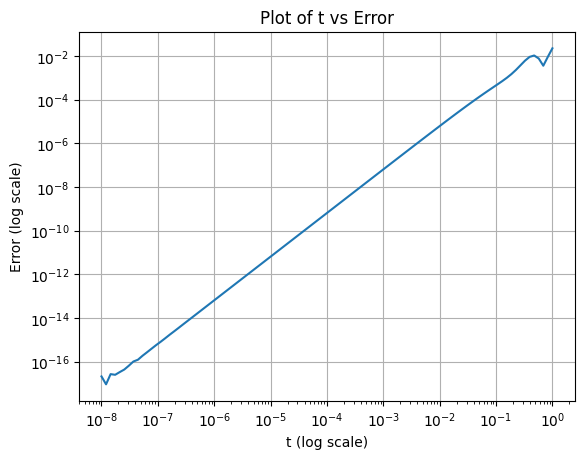

In [8]:

X_random = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape(d*K,1)  # Random X
U_random = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape(d*K,1)  # Random direction U
U_random /= np.linalg.norm(U_random)  # Normalize U

#check that the gradient is correct using
# f(x+tv)= f(x) + t<v,grad_f(x)> + t^2/2*v.T@hess_f(x)[v] + O(t^3)

# Generate a random point and a random direction
theta = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape(d*K,1)
v = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape(d*K,1)
v = v / np.linalg.norm(v)

## Check the hessian 
def checkhessian(f,grad_f,hessian_f,theta,v):
    #logspace of t values
    t=np.logspace(-8, 0, num=100)
    #intialise error to 0
    error = np.zeros_like(t)
    #pre-calculae f_lambda and f_lambda_grad to use in for loop
    f_lambda = f(theta,P,y)
    f_lambda_grad = grad_f(theta,P)
    f_lambda_hess_v = hessian_f(theta,v)
    #compute the error at each t
    for i in tqdm(range(100)):
        error[i] = np.abs(f(theta+(t[i]*v),P,y)-f_lambda-(t[i]*v.T@f_lambda_grad)- ((t[i]**2)/2)*v.T@f_lambda_hess_v)
        
    #plot the graph of error vs t
    plt.loglog(t,error)
    plt.xlabel('t (log scale)')
    plt.ylabel('Error (log scale)')
    plt.title('Plot of t vs Error')
    plt.grid()
    plt.show
checkhessian(f,grad_f,hessian_f,theta,v)

# Question 9

In [9]:
def tCG(b: np.array, radius: float) -> tuple:
    """
    Solve the trust-region subproblem using tCG

    :param b: np.array[(2, K)]
    :param radius: float
    :returns: tuple(np.array(2*K, 1), np.array(2*K, 1), bool)
    """
    global K
    b = b.reshape(-1, 1)
    v0, r0, p0 = np.zeros((2 * K, 1)), b, b  # Here, when there is a "0" after the variable, it means it's the "iterated" variable ie it changes on every loop
    while True:
        Hp = hessian_f(b, p0)
        inner = np.inner(p0.flatten(), Hp.flatten())
        alpha = np.inner(r0.flatten(), r0.flatten())/inner
        v_plus = v0 + alpha * p0
        if inner <= 0 or np.linalg.norm(v_plus) >= radius:
            inner_pv = np.inner(v0.flatten(), p0.flatten())
            norm2_p = np.inner(p0.flatten(), p0.flatten())
            t = (-np.sqrt(inner_pv) + np.sqrt(inner_pv - (inner_pv - radius**2) * norm2_p))/norm2_p
            v0 += t * p0
            return (v0, b - r0 + t*Hp, True)  # since we solved ||v0|| = Delta, the flag is true
        else:
            v0 = v_plus
        r_old = r0
        r0 -= alpha * Hp
        if np.linalg.norm(r0) <= np.linalg.norm(b) * min(np.linalg.norm(r0), 0.1):
            return (v0, b - r0, False)  # flag is false
        beta0 = np.inner(r0.flatten(), r0.flatten())/np.inner(r_old.flatten(), r_old.flatten())
        p0 = (r0.flatten() + (beta0 * p0).flatten()).reshape(6, 1)


print(tCG(grad_f(X0.flatten(), P), 0.25))


(array([[ 0.09793071],
       [-0.11065065],
       [-0.00899767],
       [-0.05651924],
       [-0.08699478],
       [ 0.17269203]]), array([[-0.42251987],
       [ 0.27960044],
       [-0.15749385],
       [-0.13342468],
       [ 0.69698297],
       [-0.40057208]]), True)


# Question 10

In [ ]:
def TRsolver(x0: np.array, Delta0: float, DeltaBar: float, rhoPrime: float=0.1, tol=0.001, time_limit = 100) -> np.array:
    """TrustRegion solver
    
    :param x0: np.ndarray[(2, K))]
    :param Delta0: float
    :param DeltaBar: float
    :param rhoPrime: float
    :returns: np.array[(2, K)]
    """
    global K, P, y
    start_time = time.time()
    gradient = 100
    iterates = []
    while gradient > tol:  # replace with while loop, with a stopping criterion
        iterates.append(x0)
        grad_x0 = grad_f(x0.flatten(), P)
        TRsub = tCG(grad_x0, Delta0)
        x0_plus = x0 + TRsub[0].reshape(2, K)
        rho = (f(x0_plus, P, y) - f(x0, P, y))/(0.5 * np.inner(TRsub[0].flatten(), TRsub[1].flatten()) + np.inner(grad_x0.flatten(), TRsub[0].flatten()))
        if rho > rhoPrime:
            x0 = x0_plus

        if rho < 0.25:
            Delta0 = 0.25 * Delta0
        elif rho > 0.75 and TRsub[2]:
            Delta0 = min(2*Delta0, DeltaBar)
        else:
            pass
        gradient = np.linalg.norm(grad_f(x0.flatten(), P))
        print(np.linalg.norm(gradient))
        if time.time() - start_time > time_limit:
            print(f"Reached time limit of {time_limit}s!")
            break
    return (x0, iterates)

print(X0.shape)
print(TRsolver(X0, delta_0, delta_bar))
        

(2, 3)
0.1300752480416098
0.15179301886712704
0.21133712997441545
0.09860276638618982
0.1009394766523371
0.1009394766523371
0.1009394766523371
0.11243872010638004
0.12793796897971452
0.16204269023612305
0.06862629904369397
0.12125296019917291
0.044339193216845686
0.044339193216845686
0.0383351828747238
0.0383351828747238
0.04634316280422691
0.04634316280422691
0.05090717262881324
0.0609929987280797
0.08485772832368683
0.14339982421389802
0.21766643756988818
0.17953016456334173
0.17953016456334173
0.0741196509695542
0.17165733449129003
0.07419243709829283
0.17166843728551515
0.0742447694018548
0.1716902463892492
0.07428699777269457
0.17172424379731333
0.07432720049808875
0.17177500308350446
0.0743730753070227
0.17185078534334053
0.07443352004575991
0.17196472390142334
0.07452013926158532
0.17213644399046074
0.07464863474556724
0.1723935989503134
0.07483955236259165
0.172771921413694
0.07511701772339383
0.17331088982781934
0.17331088982781934
0.06150414877511536
0.1809506396227269
0.0618